# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Нужно построить модель, которая умеет её определять.  В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки:**
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **Repaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

**Целевой признак:**
* **Price** — цена (евро)


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from numpy.random import RandomState
from IPython.display import display
from numpy.random import RandomState
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
!pip install category_encoders
from category_encoders import MEstimateEncoder
import category_encoders
import lightgbm
import time

#import warnings
#warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

In [ ]:
# откроем данные

data = pd.read_csv('/datasets/autos.csv')

In [ ]:
# Функция для вывода информации об изучаемых данных

def data_info(data):
    display(data.head(10))
    display(data.describe())
    print(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))

In [ ]:
data_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Выводы

* Датасет состоит из 35369 строк и  16 столбцов.
* В данным наблюдается много пропусков.
* Присутствует незначительное число дубликатов.
* Предстоит удалить лишние данные чтобы избежать переобучения, например, некоторые данные о датах и колонку NumberOfPictures.

## Предобработка данных

In [ ]:
# Удалим явные дубликаты
data = data.drop_duplicates()

**Признак DateCreated**

In [ ]:
f"Самая ранняя дата рагистрации объявления: {min(data['DateCreated'])}"

'Самая ранняя дата рагистрации объявления: 2014-03-10 00:00:00'

In [ ]:
f"Самая поздняя дата рагистрации объявления: {max(data['DateCreated'])}"

'Самая поздняя дата рагистрации объявления: 2016-04-07 00:00:00'

In [ ]:

data.loc[data['RegistrationYear'] < 1900, 'Brand'].value_counts()

sonstige_autos    14
volkswagen        14
mercedes_benz      6
opel               5
trabant            4
bmw                3
mitsubishi         2
fiat               2
ford               2
alfa_romeo         2
audi               2
citroen            2
porsche            1
land_rover         1
peugeot            1
skoda              1
renault            1
rover              1
subaru             1
chrysler           1
Name: Brand, dtype: int64

In [ ]:
# Удалим объявления, опубликованные после 2023, до 1900 года и те, год выпуска которых превышает год публикации объявления

data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data = data[(data['RegistrationYear'] >= 1900) & (data['RegistrationYear'] <= 2016) & (data['DateCreated'].dt.year >= 2014)
        & (data['RegistrationYear'] <= data['DateCreated'].dt.year)]

**Признак Price**

In [ ]:
# При просмотре данных обнаружена позиция с нулевой ценой.
# Проверим количество таких строк.

f"Количество объявлений с нулевой ценой: {len(data.loc[data['Price'] == 0])}"

'Количество объявлений с нулевой ценой: 10008'

'Количество объявлений с нулевой ценой: 10008'

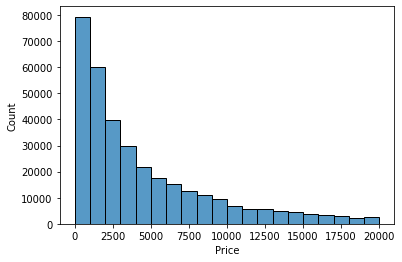

In [ ]:
# При просмотре данных обнаружена позиция с нулевой ценой.
# Проверим количество таких строк.

sns.histplot(data['Price'], bins=20)
f"Количество объявлений с нулевой ценой: {len(data.loc[data['Price'] == 0])}"

In [ ]:
data['Price'].describe()

count    339769.000000
mean       4471.332061
std        4546.037804
min           0.000000
25%        1099.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [ ]:
# Скорее всего нулевая цена - это ошибочные данные. Удалим их.

data = data.loc[data['Price'] > 1000]

**Признак Model**

In [ ]:
f"Количество объявлений с незаполненной моделью: {len(data.loc[data['Model'].isna()])}"

'Количество объявлений с незаполненной моделью: 9669'

Очевидно, что модель машины сильно влияет на цену. Отсутствующие данные помешают обучению, удалим их.

In [ ]:
data = data.loc[~data['Model'].isna()]

**Признак Power**

In [ ]:
# Рассмотрим автомобили с неправдоподобными значениями мощности

f"Количество автомобилей с мощностью > 1000 л.с.: {len(data.loc[(data['Power'] > 1000) | (data['Power'] <= 0)])}"

'Количество автомобилей с мощностью > 1000 л.с.: 15979'

In [ ]:
# Заполним все неправдоподобные значения медианными для автомобилей той же модели

data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')

<AxesSubplot:xlabel='Power', ylabel='Count'>

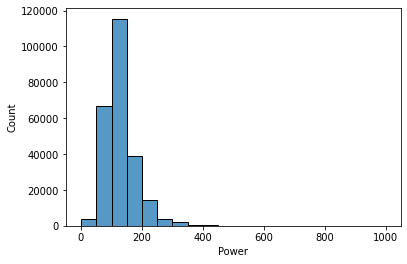

In [ ]:
sns.histplot(data['Power'], bins=20)

In [ ]:
 # Заполним пропуски для VehicleType, Gearbox и FuelType

data['VehicleType'] = data['VehicleType'].fillna(data
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['VehicleType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

In [ ]:
# Удалим избыточные признаки

data = data.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [ ]:
# Разделим признаки на числовые и категориальные

numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']

In [ ]:
# Проверим есть ли корреляция между числовыми данными

data[numerical_features].corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.429820,0.446765,-0.374446
RegistrationYear,0.429820,1.000000,0.042179,-0.280122
Power,0.446765,0.042179,1.000000,0.171870
Kilometer,-0.374446,-0.280122,0.171870,1.000000


### Вывод:

Рассмотрены предоставленые исторические данные (технические характеристики, комплектации и цены автомобилей).
* Столбцы не влияющие на целевой признак (Price) были удалены.
* Признаки были разделены на числовые и категориальные. Для категориальных признаков была проверена корреляция. Показано, что нет значительных взаимосвязей, которые могли бы негативно повлиять на обучение модели.


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Буду изучать.</font>
</div>

## Формирование выборок

In [ ]:
data_t=data

In [ ]:
# Проведем кросс-валидацию с перемешиванием подвыборок

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# Данные разделим на тестовую и обучающую выборки

X = data.drop(columns='Price')
y = data['Price']
X2 = data_t.drop(columns='Price')
y2 = data_t['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

In [ ]:
# Кодирование остальных категориальных признаков с использованием OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train[['Gearbox', 'FuelType', 'VehicleType', 'Repaired']])



OneHotEncoder(drop='first', sparse=False)

In [ ]:
# Кодирование Бренда и Модели с использованием MEstimateEncoder
me_enc = MEstimateEncoder(return_df=True)
me_enc.fit(X_train[['Model', 'Brand']], y_train)

X_train_me = pd.DataFrame(me_enc.transform(X_train[['Model', 'Brand']]), columns=me_enc.get_feature_names_out())
X_test_me = pd.DataFrame(me_enc.transform(X_test[['Model', 'Brand']]), columns=me_enc.get_feature_names_out())


In [ ]:
X_train_enc = pd.DataFrame(encoder.transform(X_train[['Gearbox', 'FuelType', 'VehicleType', 'Repaired']]))
X_test_enc = pd.DataFrame(encoder.transform(X_test[['Gearbox', 'FuelType', 'VehicleType', 'Repaired']]))


# Объединение признаков
X_train_final = X_train.drop(columns=['Model', 'Brand', 'Gearbox', 'FuelType', 'VehicleType', 'Repaired']).join(X_train_enc).join(X_train_me)
X_test_final = X_test.drop(columns=['Model', 'Brand', 'Gearbox', 'FuelType', 'VehicleType', 'Repaired']).join(X_test_enc).join(X_test_me)

X_train_final.head()


,RegistrationYear,Power,Kilometer,0,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,Model,Brand
107900,1994,102,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5902.933552,7144.577720
225214,2004,98,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3148.247013,3538.190287
142095,2004,116,125000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4237.446079,6705.798968
245092,1992,110,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5902.933552,7144.577720
238720,2014,200,30000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5814.063286,5419.772382


In [ ]:
# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final[numerical_features])
X_test_scaled = scaler.transform(X_test_final[numerical_features])

In [ ]:
print('Размер признаков на обучающей выборке', X_train.shape)
print('Размер целевой переменной на обучении', y_train.shape)
print('Размер призаков на тестовой выборке', X_test.shape)
print('Размер целевой переменной на тесте', y_test.shape)

Размер признаков на обучающей выборке (197088, 9)
Размер целевой переменной на обучении (197088,)
Размер призаков на тестовой выборке (49273, 9)
Размер целевой переменной на тесте (49273,)


In [ ]:
# Применим кодировку категориальных переменных для модели lightgbm

for c in X2.columns:
    col_type = X2[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X2[c] = X2[c].astype('category')

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, train_size=0.9)

### Выводы:

* Проведена кросс-валидация с перемешиванием выборок
* Произведено кодирование категориальных признаков
* Данные разделены на тестовую и обучающую выборки

## Обучение моделей

### CatBoostRegressor

In [ ]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')

In [ ]:
grid_cbr = {'iterations': [100, 150, 200],
        'depth': [2, 8,10]}

In [ ]:
model_cbr.grid_search(grid_cbr, X_train, y_train)

0:	learn: 7193.2284782	test: 7160.8335196	best: 7160.8335196 (0)	total: 23.7ms	remaining: 2.34s
1:	learn: 7024.2155627	test: 6991.8664529	best: 6991.8664529 (1)	total: 43ms	remaining: 2.1s
2:	learn: 6860.8170957	test: 6828.8061675	best: 6828.8061675 (2)	total: 62.6ms	remaining: 2.02s
3:	learn: 6703.5269793	test: 6671.6728248	best: 6671.6728248 (3)	total: 80.6ms	remaining: 1.93s
4:	learn: 6551.5965094	test: 6520.0758258	best: 6520.0758258 (4)	total: 102ms	remaining: 1.94s
5:	learn: 6405.4958102	test: 6374.1250564	best: 6374.1250564 (5)	total: 120ms	remaining: 1.88s
6:	learn: 6264.5097368	test: 6233.3896752	best: 6233.3896752 (6)	total: 138ms	remaining: 1.83s
7:	learn: 6126.7289135	test: 6095.7357070	best: 6095.7357070 (7)	total: 156ms	remaining: 1.79s
8:	learn: 5995.7751129	test: 5965.0460880	best: 5965.0460880 (8)	total: 174ms	remaining: 1.76s
9:	learn: 5867.8151138	test: 5837.1947383	best: 5837.1947383 (9)	total: 197ms	remaining: 1.77s
10:	learn: 5745.1912816	test: 5714.5883316	best: 

{'params': {'depth': 10, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
      

In [ ]:
%%time
score_cbr=cross_val_score(model_cbr, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error').mean()
score_cbr

Learning rate set to 0.327473
0:	learn: 3544.0067719	total: 58.5ms	remaining: 11.6s
1:	learn: 2899.9659230	total: 106ms	remaining: 10.5s
2:	learn: 2517.0233533	total: 154ms	remaining: 10.1s
3:	learn: 2285.5492008	total: 196ms	remaining: 9.6s
4:	learn: 2134.9510864	total: 248ms	remaining: 9.69s
5:	learn: 2047.1977704	total: 291ms	remaining: 9.41s
6:	learn: 1989.6345001	total: 358ms	remaining: 9.87s
7:	learn: 1932.9668296	total: 427ms	remaining: 10.2s
8:	learn: 1901.9895151	total: 467ms	remaining: 9.91s
9:	learn: 1873.7403445	total: 516ms	remaining: 9.8s
10:	learn: 1855.1604359	total: 559ms	remaining: 9.61s
11:	learn: 1840.6302580	total: 605ms	remaining: 9.48s
12:	learn: 1822.9805458	total: 646ms	remaining: 9.29s
13:	learn: 1812.7329491	total: 691ms	remaining: 9.17s
14:	learn: 1801.7509819	total: 733ms	remaining: 9.04s
15:	learn: 1792.0924564	total: 777ms	remaining: 8.94s
16:	learn: 1783.5187443	total: 821ms	remaining: 8.84s
17:	learn: 1775.4112805	total: 871ms	remaining: 8.81s
18:	learn

-1643.9201623009758

In [ ]:
%%time
res_cbr=model_cbr.fit(X_train,y_train)

Learning rate set to 0.349139
0:	learn: 3491.7331175	total: 69.9ms	remaining: 13.9s
1:	learn: 2822.8245824	total: 129ms	remaining: 12.8s
2:	learn: 2438.4523077	total: 191ms	remaining: 12.5s
3:	learn: 2216.7834106	total: 248ms	remaining: 12.1s
4:	learn: 2083.6021512	total: 313ms	remaining: 12.2s
5:	learn: 2005.7503266	total: 375ms	remaining: 12.1s
6:	learn: 1954.2951809	total: 432ms	remaining: 11.9s
7:	learn: 1912.4427090	total: 495ms	remaining: 11.9s
8:	learn: 1884.9137828	total: 561ms	remaining: 11.9s
9:	learn: 1865.6295223	total: 628ms	remaining: 11.9s
10:	learn: 1845.4776823	total: 691ms	remaining: 11.9s
11:	learn: 1831.6116165	total: 749ms	remaining: 11.7s
12:	learn: 1818.5566775	total: 813ms	remaining: 11.7s
13:	learn: 1806.2582821	total: 877ms	remaining: 11.7s
14:	learn: 1798.0571777	total: 967ms	remaining: 11.9s
15:	learn: 1792.4533806	total: 1.03s	remaining: 11.9s
16:	learn: 1783.4376520	total: 1.1s	remaining: 11.8s
17:	learn: 1772.7377552	total: 1.16s	remaining: 11.7s
18:	lear

In [ ]:
%%time
pred_cbr=res_cbr.predict(X_test)

CPU times: user 73.7 ms, sys: 43 µs, total: 73.8 ms
Wall time: 72.2 ms


### LGBMRegressor

In [ ]:
model_lgbmr=lightgbm.LGBMRegressor(random_state=12345,num_leaves=29, verbose=0)

In [ ]:
grid_lgbmr={'n_estimators': [10, 50, 100],
    'max_depth': [1, 3, 5]}

In [ ]:
grid_search_lgbmr=GridSearchCV(estimator=model_lgbmr, param_grid = grid_lgbmr, refit=True,
                               scoring = 'neg_root_mean_squared_error',cv = cv, n_jobs=-1)
opt_lgbmr=grid_search_lgbmr.fit(X2_train, y2_train)
score_lgbmr=cross_val_score(opt_lgbmr.best_estimator_, X2_train, y2_train, cv=3,
                            scoring='neg_root_mean_squared_error').mean()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.391101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.374599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.403986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325223 seconds.
You can set `force_row_wise=true` to remo

In [ ]:
%%time
res_lgbmr=model_lgbmr.fit(X_train,y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.383279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
CPU times: user 5min 37s, sys: 4.14 s, total: 5min 41s
Wall time: 5min 43s


In [ ]:
%%time
res_lgbmr=opt_lgbmr.best_estimator_.fit(X_train,y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.364328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [ ]:
%%time
pred_lgbmr=res_lgbmr.predict(X_test)

CPU times: user 358 ms, sys: 6.68 ms, total: 365 ms
Wall time: 270 ms


### RandomForestRegressor

In [ ]:
model_rfr=RandomForestRegressor(random_state=RANDOM_STATE,verbose=0)

In [ ]:
grid_rfr={'n_estimators': range(1,10),'max_depth': range(1,10)}

In [ ]:
grid_search=GridSearchCV(estimator=model_rfr, param_grid = grid_rfr, refit=True,
                         scoring = 'neg_root_mean_squared_error',cv = cv, n_jobs=-1)
opt=grid_search.fit(X_train, y_train)
score_rfr=cross_val_score(opt.best_estimator_, X_train, y_train, cv=3,
                          scoring='neg_root_mean_squared_error').mean()

In [ ]:
%%time
res_rfr=opt.best_estimator_.fit(X_train,y_train)

CPU times: user 2.48 s, sys: 39.9 ms, total: 2.52 s
Wall time: 2.53 s


In [ ]:
%%time
pred_rfr=res_rfr.predict(X_test)

CPU times: user 41.6 ms, sys: 35 µs, total: 41.6 ms
Wall time: 40.1 ms


Построены модели Случайный лес, Линейная регрессия и LightGBM. Лучший результат у модели Случайный лес.

## Анализ моделей

In [ ]:
results=[score_cbr,score_lgbmr,score_rfr]
results

[-1643.9201623009758, -1720.5520631895179, -1969.2192984348292]

In [ ]:
%%time
best = opt.best_estimator_.predict(X_test)

CPU times: user 43.7 ms, sys: 5 µs, total: 43.7 ms
Wall time: 49.5 ms


In [ ]:
mse(y_test,best)**0.5

1971.563014630746

In [ ]:
model_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

## Выводы

1. Датасет загружен, проанализирован, произведена предобработка данных:
    * Удалены явные дубликаты
    * Обработаны пропуски
    * Удалены ненужных данных, которые могли затруднить обучение
    * Изучили и обработали аномалии
    * Обработаны категриальные переменные
2. Обучены разные модели: Случайный лес, Линейная регрессия и LightGBM.
3. Проанализированы время обучения, время предсказания и качество моделей. Лучший результат у модели Случайный лес.
4. Качество лучшей модели проверено на тестовой выборке.